In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input, AveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras import applications
from keras import layers
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation
import numpy as np
import pandas as pd
from keras.optimizers import RMSprop

In [2]:
#parameters
classes = 12
batch_size=32
train_total = 3783
validation_total = 967

In [3]:
def identity_block(input_tensor, kernel_size, filters):
    filters1, filters2, filters3 = filters
    
    x = Conv2D(filters1, (1,1))(input_tensor)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters2, kernel_size, padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters3, (1,1))(x)
    x = BatchNormalization(axis=3)(x)
    
    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    
    return x

In [4]:
def conv_block(input_tensor, kernel_size, filters, strides=(2,2)):
    filters1, filters2, filters3 = filters
    
    x = Conv2D(filters1, (1,1), strides=strides)(input_tensor)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters2, kernel_size, padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters3, (1,1))(x)
    x = BatchNormalization(axis=3)(x)
    
    shortcut = Conv2D(filters3, (1,1), strides=strides)(input_tensor)
    x = BatchNormalization(axis=3)(shortcut)
    
    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [5]:
input_layer = Input((224, 224, 3))

In [6]:
x = Conv2D(64, (7,7), strides=(2,2), padding='same')(input_layer)
x = BatchNormalization(axis=3)(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3), strides=(2,2))(x)

x = conv_block(x, 3, [64,64,256],strides=(1,1))
x = identity_block(x, 3, [64,64,256])
x = identity_block(x, 3, [64,64,256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

x = conv_block(x, 3, [256,256,1024])
x = identity_block(x, 3, [256,256,1024])
x = identity_block(x, 3, [256,256,1024])
x = identity_block(x, 3, [256,256,1024])
x = identity_block(x, 3, [256,256,1024])
x = identity_block(x, 3, [256,256,1024])

x = conv_block(x, 3, [512,512,2048])
x = identity_block(x, 3, [512,512,2048])
x = identity_block(x, 3, [512,512,2048])

x = AveragePooling2D((7,7))(x)
x = Flatten()(x)
x = Dense(classes, activation='softmax')(x)

In [7]:
model = Model(inputs=input_layer,outputs=x)

In [8]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 112, 112, 64)  256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [9]:
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(lr=0.00005),
             metrics=['accuracy'])

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                   rotation_range = 20,
                                   height_shift_range=0.2,
                                   width_shift_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='reflect',
                                   horizontal_flip=True,
                                   vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
                    'train',
                    target_size=(224,224),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True
                    )
validation_generator = validation_datagen.flow_from_directory(
                        'validation',
                        target_size=(224,224),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 3783 images belonging to 12 classes.
Found 967 images belonging to 12 classes.


In [12]:
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = int(np.ceil(train_total/batch_size)),
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps= int(np.ceil(validation_total/batch_size)),
                    verbose=2)

Epoch 1/10
95s - loss: 2.1076 - acc: 0.3795 - val_loss: 3.1894 - val_acc: 0.1065
Epoch 2/10
91s - loss: 1.3429 - acc: 0.5664 - val_loss: 3.6348 - val_acc: 0.1158
Epoch 3/10
86s - loss: 1.1130 - acc: 0.6431 - val_loss: 5.8250 - val_acc: 0.1975
Epoch 4/10
85s - loss: 0.9305 - acc: 0.6917 - val_loss: 8.6459 - val_acc: 0.1686
Epoch 5/10
87s - loss: 0.8568 - acc: 0.7216 - val_loss: 4.7175 - val_acc: 0.2958
Epoch 6/10
89s - loss: 0.7585 - acc: 0.7393 - val_loss: 1.7891 - val_acc: 0.5233
Epoch 7/10
86s - loss: 0.6970 - acc: 0.7697 - val_loss: 1.4562 - val_acc: 0.6350
Epoch 8/10
86s - loss: 0.6528 - acc: 0.7681 - val_loss: 1.2422 - val_acc: 0.6660
Epoch 9/10
86s - loss: 0.6012 - acc: 0.7930 - val_loss: 1.2330 - val_acc: 0.6805
Epoch 10/10
86s - loss: 0.5255 - acc: 0.8193 - val_loss: 2.3230 - val_acc: 0.5398


In [13]:
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(lr=0.000005),
             metrics=['accuracy'])

history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = int(np.ceil(train_total/batch_size)),
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps= int(np.ceil(validation_total/batch_size)),
                    verbose=2)

Epoch 1/20
93s - loss: 0.3901 - acc: 0.8634 - val_loss: 0.3211 - val_acc: 0.8904
Epoch 2/20
86s - loss: 0.3620 - acc: 0.8757 - val_loss: 0.3004 - val_acc: 0.8842
Epoch 3/20
85s - loss: 0.3314 - acc: 0.8831 - val_loss: 0.2970 - val_acc: 0.8956
Epoch 4/20
85s - loss: 0.3354 - acc: 0.8794 - val_loss: 0.3166 - val_acc: 0.8842
Epoch 5/20
86s - loss: 0.3118 - acc: 0.8902 - val_loss: 0.2941 - val_acc: 0.8883
Epoch 6/20
85s - loss: 0.3022 - acc: 0.8902 - val_loss: 0.2839 - val_acc: 0.9059
Epoch 7/20
84s - loss: 0.2870 - acc: 0.8971 - val_loss: 0.2644 - val_acc: 0.9018
Epoch 8/20
86s - loss: 0.2874 - acc: 0.8960 - val_loss: 0.2813 - val_acc: 0.9007
Epoch 9/20
86s - loss: 0.3033 - acc: 0.8901 - val_loss: 0.2814 - val_acc: 0.8945
Epoch 10/20
84s - loss: 0.3016 - acc: 0.8895 - val_loss: 0.2706 - val_acc: 0.9080
Epoch 11/20
86s - loss: 0.2823 - acc: 0.9003 - val_loss: 0.2437 - val_acc: 0.9049
Epoch 12/20
86s - loss: 0.2837 - acc: 0.8934 - val_loss: 0.2835 - val_acc: 0.9049
Epoch 13/20
85s - loss: 0

In [14]:
model.save_weights('resnet50_from_scratch.hdf5')

In [41]:
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(lr=0.0000001),
             metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='resnet50_from_scratch_save_best.hdf5', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = int(np.ceil(train_total/batch_size)),
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps= int(np.ceil(validation_total/batch_size)),
                    verbose=2,
                    callbacks=[checkpointer])

Epoch 1/20
Epoch 00000: val_loss improved from inf to 0.19258, saving model to resnet50_from_scratch_save_best.hdf5
92s - loss: 0.1639 - acc: 0.9393 - val_loss: 0.1926 - val_acc: 0.9297
Epoch 2/20
Epoch 00001: val_loss did not improve
85s - loss: 0.1657 - acc: 0.9371 - val_loss: 0.2013 - val_acc: 0.9317
Epoch 3/20
Epoch 00002: val_loss did not improve
85s - loss: 0.1678 - acc: 0.9442 - val_loss: 0.1954 - val_acc: 0.9400
Epoch 4/20
Epoch 00003: val_loss improved from 0.19258 to 0.18912, saving model to resnet50_from_scratch_save_best.hdf5
86s - loss: 0.1682 - acc: 0.9414 - val_loss: 0.1891 - val_acc: 0.9390
Epoch 5/20


KeyboardInterrupt: 

In [40]:
model.load_weights('resnet50_from_scratch_save_best.hdf5')

In [26]:
temp_score = model.evaluate_generator(validation_generator, int(np.ceil(validation_total/batch_size)))

In [31]:
print(temp_score)

[0.16760123309206446, 0.94725956572865011]


In [32]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
                    'test',
                    shuffle=False,
                    target_size=(224,224),
                    batch_size=16,
                    class_mode=None)



Found 794 images belonging to 1 classes.


In [33]:
predictions = model.predict_generator(test_generator,int(np.ceil(794/16)))


In [34]:
class_ids = {train_generator.class_indices[x]: x for x in train_generator.class_indices}

In [35]:
predicted_classes = [class_ids[x] for x in np.argmax(predictions, axis=1)]

In [36]:
from os.path import basename
test_ids = [basename(x) for x in test_generator.filenames]

In [38]:
submission = pd.DataFrame({'file':test_ids,'species':predicted_classes})
submission.to_csv('resnet50_from_scratch.csv', encoding="utf8", index=False)

In [39]:
from IPython.display import FileLink
FileLink('resnet50_from_scratch.csv')

/home/janardhan/plant_seeding/resnet50_from_scratch.csv

In [1]:
tmp = """Epoch 1/10
95s - loss: 2.1076 - acc: 0.3795 - val_loss: 3.1894 - val_acc: 0.1065
Epoch 2/10
91s - loss: 1.3429 - acc: 0.5664 - val_loss: 3.6348 - val_acc: 0.1158
Epoch 3/10
86s - loss: 1.1130 - acc: 0.6431 - val_loss: 5.8250 - val_acc: 0.1975
Epoch 4/10
85s - loss: 0.9305 - acc: 0.6917 - val_loss: 8.6459 - val_acc: 0.1686
Epoch 5/10
87s - loss: 0.8568 - acc: 0.7216 - val_loss: 4.7175 - val_acc: 0.2958
Epoch 6/10
89s - loss: 0.7585 - acc: 0.7393 - val_loss: 1.7891 - val_acc: 0.5233
Epoch 7/10
86s - loss: 0.6970 - acc: 0.7697 - val_loss: 1.4562 - val_acc: 0.6350
Epoch 8/10
86s - loss: 0.6528 - acc: 0.7681 - val_loss: 1.2422 - val_acc: 0.6660
Epoch 9/10
86s - loss: 0.6012 - acc: 0.7930 - val_loss: 1.2330 - val_acc: 0.6805
Epoch 10/10
86s - loss: 0.5255 - acc: 0.8193 - val_loss: 2.3230 - val_acc: 0.5398
Epoch 1/20
93s - loss: 0.3901 - acc: 0.8634 - val_loss: 0.3211 - val_acc: 0.8904
Epoch 2/20
86s - loss: 0.3620 - acc: 0.8757 - val_loss: 0.3004 - val_acc: 0.8842
Epoch 3/20
85s - loss: 0.3314 - acc: 0.8831 - val_loss: 0.2970 - val_acc: 0.8956
Epoch 4/20
85s - loss: 0.3354 - acc: 0.8794 - val_loss: 0.3166 - val_acc: 0.8842
Epoch 5/20
86s - loss: 0.3118 - acc: 0.8902 - val_loss: 0.2941 - val_acc: 0.8883
Epoch 6/20
85s - loss: 0.3022 - acc: 0.8902 - val_loss: 0.2839 - val_acc: 0.9059
Epoch 7/20
84s - loss: 0.2870 - acc: 0.8971 - val_loss: 0.2644 - val_acc: 0.9018
Epoch 8/20
86s - loss: 0.2874 - acc: 0.8960 - val_loss: 0.2813 - val_acc: 0.9007
Epoch 9/20
86s - loss: 0.3033 - acc: 0.8901 - val_loss: 0.2814 - val_acc: 0.8945
Epoch 10/20
84s - loss: 0.3016 - acc: 0.8895 - val_loss: 0.2706 - val_acc: 0.9080
Epoch 11/20
86s - loss: 0.2823 - acc: 0.9003 - val_loss: 0.2437 - val_acc: 0.9049
Epoch 12/20
86s - loss: 0.2837 - acc: 0.8934 - val_loss: 0.2835 - val_acc: 0.9049
Epoch 13/20
85s - loss: 0.2730 - acc: 0.8951 - val_loss: 0.2371 - val_acc: 0.9183
Epoch 14/20
85s - loss: 0.2798 - acc: 0.8982 - val_loss: 0.2681 - val_acc: 0.9080
Epoch 15/20
86s - loss: 0.2626 - acc: 0.9104 - val_loss: 0.2415 - val_acc: 0.9204
Epoch 16/20
85s - loss: 0.2826 - acc: 0.8997 - val_loss: 0.2693 - val_acc: 0.9090
Epoch 17/20
86s - loss: 0.2567 - acc: 0.9031 - val_loss: 0.2508 - val_acc: 0.9080
Epoch 18/20
85s - loss: 0.2623 - acc: 0.9078 - val_loss: 0.2357 - val_acc: 0.9183
Epoch 19/20
86s - loss: 0.2469 - acc: 0.9082 - val_loss: 0.2491 - val_acc: 0.9193
Epoch 20/20
84s - loss: 0.2402 - acc: 0.9110 - val_loss: 0.2286 - val_acc: 0.9193
Epoch 1/20
Epoch 00000: val_loss improved from inf to 0.19258, saving model to resnet50_from_scratch_save_best.hdf5
92s - loss: 0.1639 - acc: 0.9393 - val_loss: 0.1926 - val_acc: 0.9297
Epoch 2/20
Epoch 00001: val_loss did not improve
85s - loss: 0.1657 - acc: 0.9371 - val_loss: 0.2013 - val_acc: 0.9317
Epoch 3/20
Epoch 00002: val_loss did not improve
85s - loss: 0.1678 - acc: 0.9442 - val_loss: 0.1954 - val_acc: 0.9400
Epoch 4/20
Epoch 00003: val_loss improved from 0.19258 to 0.18912, saving model to resnet50_from_scratch_save_best.hdf5
86s - loss: 0.1682 - acc: 0.9414 - val_loss: 0.1891 - val_acc: 0.9390
Epoch 5/20"""

In [2]:
tmp = tmp.splitlines()
tmp = [x for x in tmp if x[0] != 'E']
import re
train_loss = [float(re.search('loss: ([0-9\.]+)', x).group(1)) for x in tmp]
train_acc  = [float(re.search('acc: ([0-9\.]+)', x).group(1)) for x in tmp]
val_loss   = [float(re.search('val_loss: ([0-9\.]+)', x).group(1)) for x in tmp]
val_acc    = [float(re.search('val_acc: ([0-9\.]+)', x).group(1)) for x in tmp]
import matplotlib.pyplot as plt
%matplotlib inline

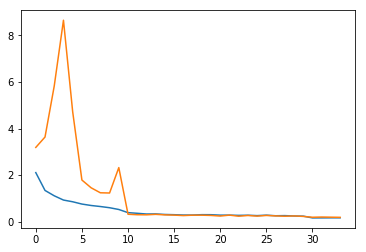

In [3]:
plt.plot(range(len(train_loss)), train_loss,
         range(len(train_loss)), val_loss);

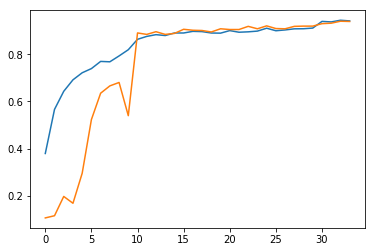

In [4]:
plt.plot(range(len(train_loss)), train_acc,
         range(len(train_loss)), val_acc);

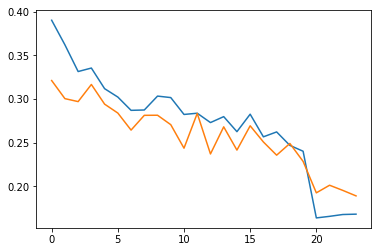

In [5]:
plt.plot(range(len(train_loss[10:])), train_loss[10:],
         range(len(train_loss[10:])), val_loss[10:]);

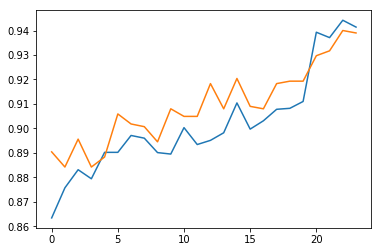

In [6]:
plt.plot(range(len(train_loss[10:])), train_acc[10:],
         range(len(train_loss[10:])), val_acc[10:]);

In [ ]:
# PB LB: 0.92695